In [310]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np 

- Use SAM to convert the points to mask
- Use cv2 to convert the mask to polygons
- Use Yolo to train detector

In [311]:
wbc_keys = {
    'N' : "Neutrophil",
    'L' : "Lymphocyte",
    'M' : "Monocyte",
    'E' : "Eosinophil",
    'B' : "Basophil"}

In [312]:
set4_df = pd.read_excel(r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Set4-1_TrainingData_20210526.xlsx", index_col=None)
set4_df = set4_df[set4_df.columns[:-2]]
set4_df["Animal Date"] = pd.to_datetime(set4_df["Animal Date"])
set4_df.head()

,Animal ID,Animal Date,Image ID,Image File,X - Coordinate (pixels),Y - Coordinate (pixels),WBC Classification,Notes
0,18Z,2015-11-18,55725659,A014_18Z_T15092_MID_x40_z0_i01j06.jpg,183.158041,183.723337,N,NaN
1,18Z,2015-11-18,55726671,A014_18Z_T15092_MID_x40_z0_i01j29.jpg,553.240189,881.145615,L,NaN
2,18Z,2015-11-18,55727023,A014_18Z_T15092_MID_x40_z0_i01j37.jpg,132.485428,848.322662,M,NaN
3,18Z,2015-11-18,55727111,A014_18Z_T15092_MID_x40_z0_i01j39.jpg,278.249268,372.937531,E,NaN
4,18Z,2015-11-18,55727199,A014_18Z_T15092_MID_x40_z0_i01j41.jpg,821.308731,391.878166,N,NaN


In [313]:
val_counts_set4 = set4_df['WBC Classification'].value_counts(ascending=True)

In [314]:
set5_df = pd.read_excel(r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Set5-1_TrainingData_20220413.xlsx", index_col=None)
set5_df = set5_df[set5_df.columns[:-2]]
set5_df["Animal Date"] = pd.to_datetime(set5_df["Animal Date"])
set5_df.head()

,Animal ID,Animal Date,Image ID,Image File,X - Coordinate (pixels),Y - Coordinate (pixels),WBC Classification,# Users ID'd Cell
0,0J4,2019-12-12,71045529,B001_0J4_T19085_RT_x40_z0_i01j40.jpg,211,181,M,10
1,0J4,2019-12-12,71045535,B001_0J4_T19085_RT_x40_z0_i02j24.jpg,871,280,N,10
2,0J4,2019-12-12,71045545,B001_0J4_T19085_RT_x40_z0_i02j34.jpg,960,817,N,9
3,0J4,2019-12-12,71045548,B001_0J4_T19085_RT_x40_z0_i02j37.jpg,162,322,N,9
4,0J4,2019-12-12,71045548,B001_0J4_T19085_RT_x40_z0_i02j37.jpg,332,21,N,9


In [315]:
val_counts_set5 = set5_df["WBC Classification"].value_counts(ascending=True)

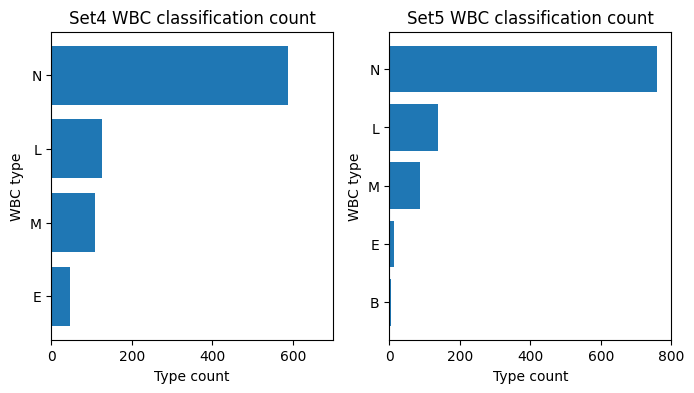

In [316]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax1.barh(val_counts_set4.index, val_counts_set4.values)
ax1.set_title("Set4 WBC classification count")
ax1.set_ylabel("WBC type")
ax1.set_xlabel("Type count")
ax1.set_xlim(0,700)


ax2.barh(val_counts_set5.index, val_counts_set5.values)
ax2.set_title("Set5 WBC classification count")
ax2.set_ylabel("WBC type")
ax2.set_xlabel("Type count")
ax2.set_xlim(0,800)
plt.show()

Combine both dataframes

In [317]:
df1 = set4_df.iloc[:,:-1]
df1['set'] = "Set4"
df2 = set5_df.iloc[:,:-1]
df2['set'] = "Set5"
total_df = pd.concat([df1, df2], axis=0)
total_df = total_df.rename(columns={"X - Coordinate (pixels)": "x_coord", "Y - Coordinate (pixels)": "y_coord", "WBC Classification": "wbc_class"})
total_df['x_coord'] = total_df['x_coord'].astype(int)
total_df['y_coord'] = total_df['y_coord'].astype(int) 
total_df['wbc_class'] = total_df['wbc_class'].astype('category')
total_df['set'] = total_df['set'].astype('category')
total_df.head()

,Animal ID,Animal Date,Image ID,Image File,x_coord,y_coord,wbc_class,set
0,18Z,2015-11-18,55725659,A014_18Z_T15092_MID_x40_z0_i01j06.jpg,183,183,N,Set4
1,18Z,2015-11-18,55726671,A014_18Z_T15092_MID_x40_z0_i01j29.jpg,553,881,L,Set4
2,18Z,2015-11-18,55727023,A014_18Z_T15092_MID_x40_z0_i01j37.jpg,132,848,M,Set4
3,18Z,2015-11-18,55727111,A014_18Z_T15092_MID_x40_z0_i01j39.jpg,278,372,E,Set4
4,18Z,2015-11-18,55727199,A014_18Z_T15092_MID_x40_z0_i01j41.jpg,821,391,N,Set4


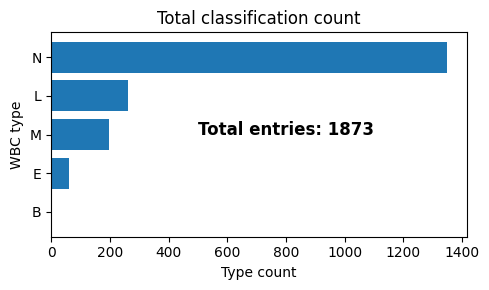

In [318]:
total_val_counts = total_df['wbc_class'].value_counts(ascending=True)
total_val_counts
fig, ax = plt.subplots(figsize=(5,3))
ax.barh(total_val_counts.index, total_val_counts.values)
ax.set_title("Total classification count")
ax.set_ylabel("WBC type")
ax.set_xlabel("Type count")
ax.text(x=500,y=2,s=f"Total entries: {str(len(total_df))}", fontsize='large', fontweight='bold')
plt.tight_layout()
plt.show()

In [319]:
basos = total_df[total_df['wbc_class'] == "B"]
basos

,Animal ID,Animal Date,Image ID,Image File,x_coord,y_coord,wbc_class,set
104,77I,2019-12-16,71046046,B014_77I_T19095_RT_x40_z0_i02j07.jpg,979,508,B,Set5
234,8A7,2019-11-12,71047283,B034_8A7_T19084_RT_x40_z0_i14j32.jpg,270,431,B,Set5
251,8A7,2019-11-12,71047456,B034_8A7_T19084_RT_x40_z0_i22j26.jpg,196,606,B,Set5
701,2I1,NaT,71050020,N19120_2I1_N19120_RT_x40_z0_i01j20.jpg,686,759,B,Set5


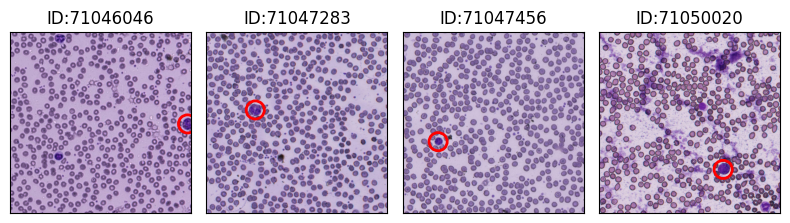

In [320]:
fig, ax = plt.subplots(nrows=1,ncols=len(basos),figsize=(8,4))
for i in range(len(basos)):
    img = cv2.imread(filename=(Path()/r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Set5-1_WBC_Images" / basos.iloc[i]["Image File"]).as_posix()) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].add_patch(plt.Circle((basos.iloc[i]['x_coord'], basos.iloc[i]['y_coord']), radius=50, color='red', fill=False, linewidth=2))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f"ID:{basos.iloc[i]['Image ID']}")
plt.tight_layout()
plt.show()

## Data agumentations

- Flip the images
- Copy some of the cells and paste them into slides with no WBCs
- For each augmentation - create an entry in a CVS file to match the data
- The same file can contain other WBCs

In [321]:
# Type alias
Coordinates = tuple[int, int]

In [322]:
def rotate_point_clockwise(x:int, y:int, image_size:tuple[int, int]) -> tuple[int, int]:
    ''' Takes a tuple of x,y points and returns the positions if
        rotated by 90 degrees clockwise'''
    assert len(image_size) == 2, "image_shape should be (height, width)"
    height, _ = image_size
    new_x = height - y
    new_y = x
    return new_x, new_y

In [323]:
def rotate_image_point(img:np.ndarray, points:Coordinates) -> tuple[np.ndarray, Coordinates]:
    """ Takes an image and point coordinates -> rotates the image and returns the rotated 
        image and rotated point coordinates """
    rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    rotated_pts = rotate_point_clockwise(points[0], points[1], image_size=img.shape[:2])
    return rotated_img, rotated_pts


In [385]:
def validate_file_path(file_path:str|Path) -> str:
    """ Checks to see if the file path is valid """
    if not isinstance(file_path, (str, Path)):
        raise ValueError(f"{file_path} must be a str or Path object")
    if isinstance(file_path, str):
        file_path = Path(file_path)
    if not file_path.is_file():
        raise FileNotFoundError(f"Cannot find this file -> {file_path} ")
    return file_path.as_posix()

In [324]:
def get_image_from_path(file_path:str | Path) -> np.ndarray:
    """ Takes an file path and returns an image as array """
    file_path = validate_file_path(file_path= file_path)
    img = cv2.imread(filename=file_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [386]:
def save_image_to_path(image:np.ndarray, file_path:str|Path) -> None:
    """ Takes an image array converts it to BGR and saves to disk in RGB"""
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename = file_path, img = img_bgr)


In [325]:
img = get_image_from_path((Path()/r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Set5-1_WBC_Images" / basos.iloc[0]["Image File"]).as_posix())

rotate1_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
rotate1_pts = rotate_point_clockwise(basos.iloc[0]["x_coord"], basos.iloc[0]["y_coord"], image_size=img.shape[:2])
rotate2_img, rotate2_pts = rotate_image_point(img = rotate1_img, points=rotate1_pts) 
rotate3_img, rotate3_pts = rotate_image_point(img = rotate2_img, points= rotate2_pts)

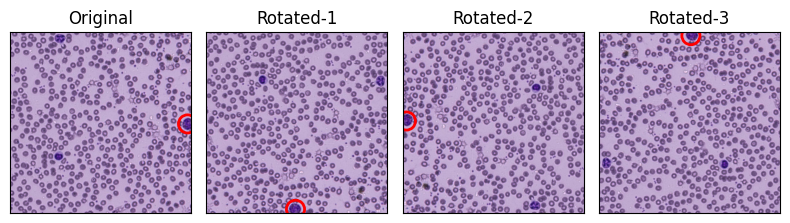

In [326]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(8,4))

images = [img, rotate1_img, rotate2_img, rotate3_img]
points = [(basos.iloc[0]["x_coord"], basos.iloc[0]["y_coord"]), rotate1_pts, rotate2_pts, rotate3_pts]
titles = ["Original", "Rotated-1", "Rotated-2", "Rotated-3"]

for i, (image, point, title) in enumerate(zip(images, points, titles)):

    axs[i].imshow(image)
    axs[i].add_patch(plt.Circle(point, radius=50, color='red', fill=False, linewidth=2))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(title)

plt.tight_layout()
plt.show()


- Create a folder for augmention images
- Create a CSV
- Rotate image -> add to folder and CSV

In [327]:
# Create an folder with the augmentation images
aug_images_folder_path = Path() /r"AI Training Sets-20231024T092556Z-001\AI Training Sets" / 'Augmentated_Images'
if not aug_images_folder_path.is_dir():
    aug_images_folder_path.mkdir()

In [328]:
# Create a csv with the data of augmentations
aug_csv_path:str = (Path() / r"AI Training Sets-20231024T092556Z-001\AI Training Sets" / "Augmentation_data.csv").as_posix()
if not Path(aug_csv_path).is_file():
    aug_df = pd.DataFrame(columns=["Original file", "Image File","x_coord","y_coord","wbc_class", 'set'])
    aug_df.to_csv(aug_csv_path, index=False)

In [329]:
def write_to_aug_csv(row_dict:dict, aug_csv_path:str) -> None:
    """ Takes row values in the form of a dict and appends 
        it to the augmentions' csv """
    aug_csv_df:pd.DataFrame = pd.read_csv(filepath_or_buffer= aug_csv_path)
    aug_csv_df.loc[len(aug_csv_df)] = row_dict
    aug_csv_df.to_csv(aug_csv_path, index=False)

In [330]:
def image_augmented_check(image_info:pd.Series, aug_cvs_path:str) -> bool:
    """ Returns true if an image has been augmented """
    aug_df = pd.read_csv(aug_cvs_path)
    return image_info["Image File"] in set(aug_df['Original file'].values)

In [331]:
# Check the shape of the images -> quarantine bad ones

bad_shape = []

for file_path in (Path() / r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Set4-1_WBC_Images").iterdir():
    img = get_image_from_path(file_path=file_path.as_posix())
    if img.shape == (1000,1000,3):
        continue
    else:
        bad_shape.append(file_path.parts[-1])


for file_path in (Path() / r"AI Training Sets-20231024T092556Z-001/AI Training Sets/Set5-1_WBC_Images").iterdir():
    img = get_image_from_path(file_path=file_path.as_posix())
    if img.shape == (1000,1000,3):
        continue
    else:
        bad_shape.append(file_path.parts[-1])

In [533]:
def rotate_augmentation(image_info:pd.Series, images_df:pd.DataFrame, aug_csv_path:str, aug_images_folder_path:str, bad_shape:list) -> None:
    """ Takes an image info row, rotates the image 3 times clockwise, adds the rotated
        images to a folder, add point coordinates to csv file. Checks to see if there are 
        more than 1 WBC in the same image and adds those to folder and file as well """

    if image_augmented_check(image_info= image_info, aug_cvs_path= aug_csv_path):
        print(f"{image_info['Image File']} has already been agumented")
        return

    if image_info['Image File'] in bad_shape: 
        return

    image_folder_dict = {'Set5': Path()/ r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Set5-1_WBC_Images",
                         'Set4': Path() / r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Set4-1_WBC_Images"}
    image_path = (image_folder_dict[image_info['set']] / image_info['Image File']).as_posix()
    img = get_image_from_path(file_path= image_path)
    assert img.shape == (1000,1000,3), "img not correct shape for augmentation"
    
    # Get all instances WBCs of the image
    filter_mask = images_df['Image File'] == image_info['Image File'] 
    multi_wbc_df:pd.DataFrame = images_df[["x_coord","y_coord","wbc_class"]][filter_mask].copy()
    
    for i in range(3): # Rotate the image 3 times clockwise
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        file_name = f"{image_info['Image ID']}_r{i}.jpg"
        file_path = (Path() / aug_images_folder_path / file_name).as_posix()
        save_image_to_path(image= img, file_path= file_path)
        
        for row_idx in multi_wbc_df.index:
            x,y = multi_wbc_df.loc[row_idx,["x_coord","y_coord"]]
            x,y = rotate_point_clockwise(x = x, y = y, image_size = img.shape[:2])
            multi_wbc_df.loc[row_idx,["x_coord","y_coord"]] = x,y
            row_dict = {
                'Original file': image_info['Image File'],
                'Image File': file_name,
                'x_coord': x,
                'y_coord': y,
                'wbc_class': multi_wbc_df.loc[row_idx,'wbc_class'],
                'set': image_info['set']
            }
            write_to_aug_csv(row_dict= row_dict, aug_csv_path= aug_csv_path)

In [534]:
rotate_augmentation(image_info= basos.iloc[0], 
                    images_df= total_df, 
                    aug_csv_path= aug_csv_path, 
                    aug_images_folder_path=aug_images_folder_path, 
                    bad_shape= bad_shape)

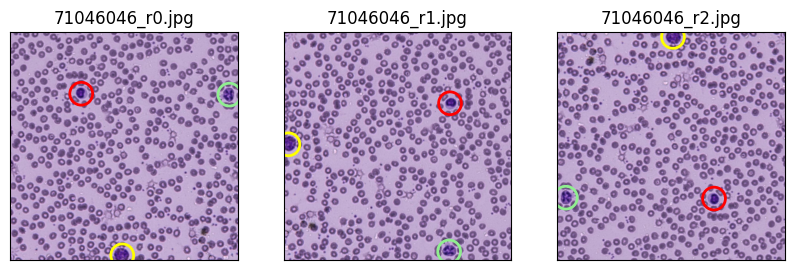

In [576]:
agu_df = pd.read_csv(aug_csv_path)
grouped = agu_df.groupby('Image File')

fig, axs = plt.subplots(nrows=1, ncols=grouped.ngroups, figsize=(10,6))

colors = {'L': 'red', 'B': 'yellow', 'N': 'lightgreen'}

for i, (image_file, image_data_df) in enumerate(grouped):
    for row_idx in image_data_df.index:
        img = get_image_from_path(file_path= aug_images_folder_path/image_file)
        axs[i].imshow(img)
        x,y, wbc = image_data_df.loc[row_idx,['x_coord', 'y_coord','wbc_class']]
        marker_color = colors.get(wbc, 'black')
        axs[i].add_patch(plt.Circle((x,y), radius=50, color=marker_color, fill=False, linewidth=2))
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(image_file)

plt.show()

In [ ]:
# Rotate all basos
for row_idx in basos.index:
    rotate_augmentation(image_info= basos.loc[row_idx],
                        images_df= total_df,
                        aug_csv_path= aug_csv_path,
                        aug_images_folder_path=aug_images_folder_path,
                        bad_shape= bad_shape)

In [580]:
agu_df = pd.read_csv(aug_csv_path)
agu_df.value_counts('wbc_class')

wbc_class
B    12
L     6
N     3
Name: count, dtype: int64

Add synthetic data

In [585]:
# Check if no_wbc folder and goldilocks good have any common images

goldilocks_good_folder = Path() / r"AI Training Sets-20231024T092556Z-001\AI Training Sets\Goldilocks-Test_Images\Good"

no_wbc_folder = Path() / r"AI Training Sets-20231024T092556Z-001\AI Training Sets\No_WBCs_Images"

goldilocks_good_files = [file.parts[-1] for file in goldilocks_good_folder.iterdir()]

no_wbc_files = [file.parts[-1] for file in no_wbc_folder.iterdir()]

good_and_no_wbc_files = list(set(goldilocks_good_files) & set(no_wbc_files))    

In [586]:
good_and_no_wbc_files

['A014_18Z_T15092_MID_x40_z0_i01j02.jpg',
 'A043_2M3_T15148_MID_x40_z0_i03j27.jpg',
 'A019_1J0_T15075_MID_x40_z0_i01j36.jpg',
 'A013_12Z_T15127_MID_x40_z0_i12j39.jpg',
 'A019_1J0_T15075_MID_x40_z0_i01j37.jpg']